# Main Components of Deep Learning Architectures

We will now move from basic fully connected layers to networks with convolutional layers and normalization layers. 
- How to implement a simple convolutional neural network using PyTorch.


In [1]:
# Let's start by importing torch (you might need to pip install if you haven't already)
import torch 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Get the MNIST dataset
# Set up the data preprocessing and loading:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])  # transform the data to torch tensor and normalize
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Now let's split the training set into a training and validation set
generator = torch.Generator().manual_seed(42)  # just a random generator
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000], generator=generator)

print('We loaded {} training, {} validation, and {} testing samples'.format(len(train_dataset), len(val_dataset), len(test_dataset)))

# Set up the data loaders (they are iterable objects that return the data in batches)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We loaded 50000 training, 10000 validation, and 10000 testing samples


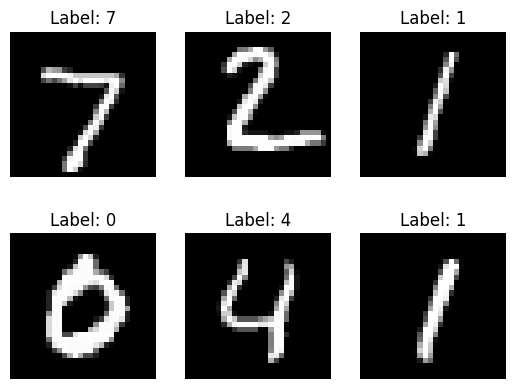

In [2]:
# Visualize some of the data 
import matplotlib.pyplot as plt
import numpy as np

examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)
images = images.numpy()  # convert images to numpy for display
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i][0], cmap='gray'); plt.axis('off')
    plt.title('Label: {}'.format(labels[i]))

### Let's compare a fully connected network with a convolutional network

In [15]:
# Let's define the neural network architecture to learn how to classify the images
import torch.nn as nn

# Define the model 
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.logsoftmax(self.fc3(x))
        return x


# Define the model 
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.reluconv1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.reluconv2 = nn.ReLU() 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(7*7*64, 16)  
        self.relufc1 = nn.ReLU() 
        self.fc2 = nn.Linear(16, 10) 
        self.logsoftmax = nn.LogSoftmax(dim=1) 
    def forward(self, x):
        x = self.reluconv1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.reluconv2(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1, 7*7*64)
        x = self.relufc1(self.fc1(x))
        x = self.logsoftmax(self.fc2(x))
        return x

# ----------------------------------------------------------------------------- 
# Excersise 1: Define the input and output sizes of each tensor in the model
# -----------------------------------------------------------------------------
# super(CNNNet, self).__init__()
# self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Nx1x28x28 -> Nx32x28x28 
# self.reluconv1 = nn.ReLU() # ? -> ?
# self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # ? -> ?
# self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # ? -> ?
# self.reluconv2 = nn.ReLU() # ? -> ?
# self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # ? -> ?
# self.fc1 = nn.Linear(7*7*64, 128)  # ? -> ?
# self.relufc1 = nn.ReLU() # ? -> ?
# self.fc2 = nn.Linear(128, 10) # ? -> ?
# self.logsoftmax = nn.LogSoftmax(dim=1) # ? -> ?
# -----------------------------------------------------------------------------


### Excersice 2: Draw a schematic representation of both models and how many trainable parameters does it have? Now many parameters the models would have if the input image was 100x100 and 1000x1000 pixels respectively? 

In [16]:
# Let's visualize the model graph with tensorboard
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
cnnmodel = CNNNet()
batch_idx, (images, labels) = next(examples)
writer.add_graph(cnnmodel, images)
writer.close()

## Now let's train both models and compare them

In [17]:
# Now let's train the model
import torch.optim as optim

def train_model(model=None, train_loader=None, val_loader=None, log_folder=None):
    num_epochs = 10 
    writer = SummaryWriter(log_folder)  # create a tensorboard writer to log the training process
    criterion = nn.CrossEntropyLoss()  # define the loss function as the cross entropy loss
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # define the optimizer (in this case stochastic gradient descent)

    for epoch in range(num_epochs):
        model.train()  # set the model to training mode
        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()  # zero the gradients
            output = model(images)  # forward pass
            loss = criterion(output, labels)  # compute the loss
            loss.backward()  # backward pass
            optimizer.step()  # update the weights

            if batch_idx % 1000 == 0:
                writer.add_scalar('training loss', loss.item(), epoch*len(train_loader)+batch_idx)
                def compute_model_accuracy(dataloader, model):
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for images, labels in dataloader:  # This will iterate over the batches of the dataloader and compute the accuracy for the samples in the batch
                            outputs = model(images)  # Compute the output of the model (it a bunch of scores for each potential label)
                            _, predicted = torch.max(outputs.data, 1)  # Assign the predicted label as the one with the highest score
                            total += labels.size(0)  # Number of samples in the batch
                            correct += (predicted == labels).sum().item()  # Number of correctly classified samples in the batch
                    return correct / total  # Return the accuracy 
                val_accuracy = compute_model_accuracy(val_loader, model)
                train_accuracy = compute_model_accuracy(train_loader, model)
                writer.add_scalar('validation accuracy', val_accuracy, epoch*len(train_loader)+batch_idx)
                writer.add_scalar('training accuracy', train_accuracy, epoch*len(train_loader)+batch_idx)
    return model

In [18]:
fcmodel = FCNet()
fcmodel = train_model(model=fcmodel, train_loader=train_loader, val_loader=val_loader, log_folder="torchlogs/fcnet")

In [19]:
cnnmodel = CNNNet()
cnnmodel = train_model(model=cnnmodel, train_loader=train_loader, val_loader=val_loader, log_folder="torchlogs/cnnnet")

### Excercise 3: Add backnormalization layers to the convolutional network and compare the results. Extra:: compare other normalization layers. 

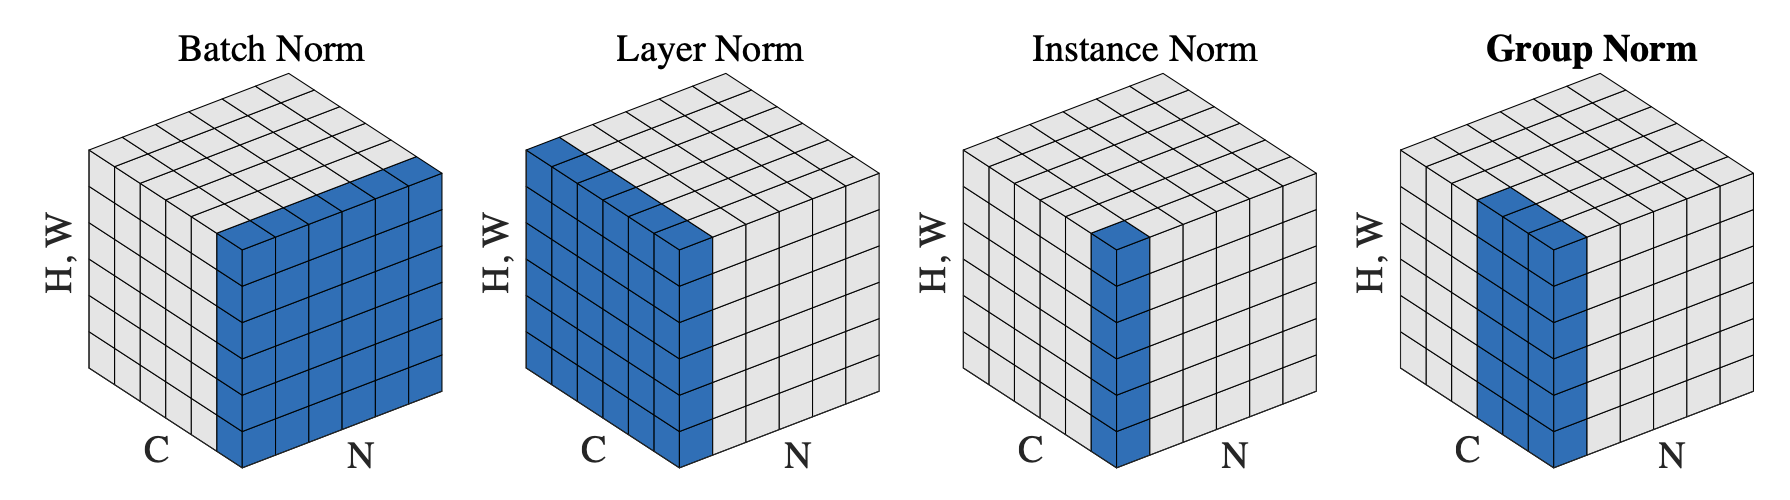


### Excersise 4: Plot the distribution of activation values for the first 3 neurons of the first FC layer, both for the models with BachNorm and without. 

### Excercise 5: Compare different optimization algorithms and compare their performance and training curves. In particular, explain the differences between adam and sgd.